In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

In [2]:
%matplotlib inline 

import pandas as pd
import os
import datetime as dt
from datetime import date
from datetime import timedelta
import dateutil.parser as dup
import dateutil.relativedelta as rd

In [3]:
%aimport trans.data
from trans.data import GetData

start = dt.datetime(2000, 1, 1)
today = dt.datetime.combine( date.today(), dt.time.min)
today
gd = GetData()

datetime.datetime(2018, 3, 20, 0, 0)

In [4]:

from trans.gtrans import *
from trans.reg import Reg, RegAttr
from trans.regpipe import RegPipe

## Usually the Adj Close and Close fields are close in value in Yahoo
### However, around dividends, the fields diverge backwards in time from the payment date
### It seems that eventually Yahoo repopulates the data and the difference disappears again
### There is a SPY divident of 1.09 on 3/16/2018 that is causing a big divergence.
### The percent changes are close EXCEPT on the start of the week of the dividend, i.e., 03/09/2018
## Althoug Adj Close is more correct (since two tickers pay dividends at different times), we may need to use Close (which is what PX_LAST on Bloomber is) to eliminate one big returns

In [5]:
close_field = "Adj Close" # "Close"

In [6]:
existing_tickers = gd.existing()
existing_tickers.sort()
len(existing_tickers)

911

In [7]:
req_tickers = [ "FB", "NFLX", "BA", "AVGO", "MCHP", "AKAM", "MRVL", "EA", "MSFT"]
exp_tickers = list( set(existing_tickers).union( req_tickers ) )
exp_tickers.sort()
len(exp_tickers)

911

In [8]:
cleaned = gd.clean_data( exp_tickers )
cleaned

[]

In [9]:
update_data = False

In [10]:
if update_data:
    changed_tickers = gd.get_data( exp_tickers, start, today )
    print("Number of tickers updated: {}", len(changed_tickers))
        

## Create sector residuals

In [11]:
sector_tickers = ['SPY',
 'XLY',
 'XLP',
 'XLE',
 'XLF',
 'XLV',
 'XLI',
 'XLB',
 'XLRE',
 'XLK',
 'XTL',
 'XLU']

price_df = GetDataTransformer(sector_tickers, cal_ticker="SPY").fit_transform( pd.DataFrame())

In [12]:
pipe_pct   = make_pipeline(GenSelectAttrsTransformer([ close_field], dropSingle=False),
                           pctTrans,
                           GenRenameAttrsTransformer(lambda col: "Pct", level=0)
                          )
pct_df = pipe_pct.fit_transform(price_df)

transform: pandas version <= 0.20.


## NOTE: we are NOT using the Residual stack b/c that object only gives residuals, and not access to the betas (which we want to observe)

In [13]:
end = dup.parse("03/16/2018")
window = rd.relativedelta(months=+6)

regStarts = end - window + timedelta(days=1)
regStarts, end
pct_dfs = pct_df.loc[ regStarts:end,:]

rps = RegPipe( pct_dfs )
rps.indCols( [ idx["Pct", "SPY"] ] )
rps.regressSingle()

rps.beta_df.shape

(datetime.datetime(2017, 9, 17, 0, 0), datetime.datetime(2018, 3, 16, 0, 0))

IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLB'), cols [('Pct', 'SPY'), ('Pct', 'XLB')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLE'), cols [('Pct', 'SPY'), ('Pct', 'XLE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLF'), cols [('Pct', 'SPY'), ('Pct', 'XLF')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLI'), cols [('Pct', 'SPY'), ('Pct', 'XLI')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLK'), cols [('Pct', 'SPY'), ('Pct', 'XLK')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLP'), cols [('Pct', 'SPY'), ('Pct', 'XLP')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLRE'), cols [('Pct', 'SPY'), ('Pct', 'XLRE')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLU'), cols [('Pct', 'SPY'), ('Pct', 'XLU')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLV'), cols [('Pct', 'SPY'), ('Pct', 'XLV')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XLY'), cols [('Pct', 'SPY'), ('Pct', 'XLY')]
IndCols: [('Pct', 'SPY')], depCol ('Pct', 'XTL'), cols [('Pct', 'SPY'), ('Pct', 'XTL')]


(1, 22)

In [14]:
rps.beta_df
rps.beta_df.to_csv("sector_residuals_beta_03162018.csv")

Beta 0                                                    \
                 XLB       XLE       XLF       XLI       XLK       XLP   
Dt                                                                       
2018-03-16 -0.000333 -0.000528  0.000396  0.000006  0.000453 -0.000767   

                                                   ...       Beta 1            \
               XLRE      XLU       XLV      XLY    ...          XLE       XLF   
Dt                                                 ...                          
2018-03-16 -0.00081 -0.00088 -0.000456  0.00059    ...     0.970388  1.097425   

                                                                               \
                 XLI      XLK       XLP      XLRE      XLU      XLV       XLY   
Dt                                                                              
2018-03-16  1.035374  1.18031  0.674372  0.582693  0.36258  0.94742  0.896174   

                      
                 XTL  
Dt                    
2018-03-16  0.834239  

[1 rows x 22 columns]

In [15]:
rollAmount = 0
fillMethod = "bfill"

rps.attrib_setup(pct_dfs, rps.beta_df, rollAmount, fillMethod)
rps.attrib()

rps.retAttr_df.shape

sector_residuals = rps.retAttr_df.loc[:, idx["Error",:]]

(125, 44)

In [16]:
sector_residuals.to_csv("sector_residuals_03162018.csv")

## Rename residuals attribute from Error to Tilt

In [17]:
pipe_rename   = make_pipeline(GenSelectAttrsTransformer(['Error'], dropSingle=False),
                              GenRenameAttrsTransformer(lambda col: "Tilt", level=0)
                          )
sector_residuals = pipe_rename.fit_transform(sector_residuals)

transform: pandas version <= 0.20.


## Retrieve the non-tilt tickers and compute returns

In [18]:
price_df = GetDataTransformer(req_tickers, cal_ticker="SPY").fit_transform( pd.DataFrame())
pct_df = pipe_pct.fit_transform(price_df)


transform: pandas version <= 0.20.


## Create single DataFrame with ticker and tilt returns

In [19]:
pct_df.index.min(), pct_df.index.max()
sector_residuals.index.min(), sector_residuals.index.max()

(Timestamp('2000-01-03 00:00:00'), Timestamp('2018-03-19 00:00:00'))

(Timestamp('2017-09-18 00:00:00'), Timestamp('2018-03-16 00:00:00'))

In [20]:
reg_df = DataFrameConcat( [ pct_df.loc[ sector_residuals.index.min():sector_residuals.index.max(),:], sector_residuals]).fit_transform( pd.DataFrame())

## Do the regression for the Info Tech sector

In [22]:
xlk = tuple(("Tilt", "XLK"))

In [23]:
cols = list( (map(lambda t: ("Pct", t), req_tickers)) )
cols.append( ("Tilt", "XLK"))
cols

# cols = [ ("Pct", "BA"), ("Pct", "SPY") , ("Tilt", "XLK")]

[('Pct', 'SPY'),
 ('Pct', 'FB'),
 ('Pct', 'NFLX'),
 ('Pct', 'BA'),
 ('Pct', 'AVGO'),
 ('Pct', 'MCHP'),
 ('Pct', 'AKAM'),
 ('Pct', 'MRVL'),
 ('Pct', 'EA'),
 ('Pct', 'MSFT'),
 ('Tilt', 'XLK')]

In [24]:
end = dup.parse("03/16/2018")
window = rd.relativedelta(months=+6)

regStarts = end - window + timedelta(days=1)
regStarts, end
reg_dfs = reg_df.loc[ regStarts:end,cols]

rps = RegPipe( reg_dfs )
rps.indCols( [ idx["Pct", "SPY"],
               idx["Tilt", "XLK"] ] )
rps.regressSingle()

rps.beta_df.shape

(datetime.datetime(2017, 9, 17, 0, 0), datetime.datetime(2018, 3, 16, 0, 0))

IndCols: [('Pct', 'SPY'), ('Tilt', 'XLK')], depCol ('Pct', 'FB'), cols [('Pct', 'SPY'), ('Tilt', 'XLK'), ('Pct', 'FB')]
IndCols: [('Pct', 'SPY'), ('Tilt', 'XLK')], depCol ('Pct', 'NFLX'), cols [('Pct', 'SPY'), ('Tilt', 'XLK'), ('Pct', 'NFLX')]
IndCols: [('Pct', 'SPY'), ('Tilt', 'XLK')], depCol ('Pct', 'BA'), cols [('Pct', 'SPY'), ('Tilt', 'XLK'), ('Pct', 'BA')]
IndCols: [('Pct', 'SPY'), ('Tilt', 'XLK')], depCol ('Pct', 'AVGO'), cols [('Pct', 'SPY'), ('Tilt', 'XLK'), ('Pct', 'AVGO')]
IndCols: [('Pct', 'SPY'), ('Tilt', 'XLK')], depCol ('Pct', 'MCHP'), cols [('Pct', 'SPY'), ('Tilt', 'XLK'), ('Pct', 'MCHP')]
IndCols: [('Pct', 'SPY'), ('Tilt', 'XLK')], depCol ('Pct', 'AKAM'), cols [('Pct', 'SPY'), ('Tilt', 'XLK'), ('Pct', 'AKAM')]
IndCols: [('Pct', 'SPY'), ('Tilt', 'XLK')], depCol ('Pct', 'MRVL'), cols [('Pct', 'SPY'), ('Tilt', 'XLK'), ('Pct', 'MRVL')]
IndCols: [('Pct', 'SPY'), ('Tilt', 'XLK')], depCol ('Pct', 'EA'), cols [('Pct', 'SPY'), ('Tilt', 'XLK'), ('Pct', 'EA')]
IndCols: [('Pct', 'S

(1, 27)

In [25]:
reg_dfs.to_csv("ticker_returns_03162018.csv")
reg_dfs.tail()

Pct                                                    \
                 SPY        FB      NFLX        BA      AVGO      MCHP   
Dt                                                                       
2018-03-12 -0.004847 -0.002537 -0.030594 -0.029138  0.035700  0.012832   
2018-03-13 -0.006463 -0.015588 -0.016869 -0.016038 -0.006163 -0.022047   
2018-03-14 -0.005132  0.012701  0.017950 -0.024832 -0.002412 -0.007957   
2018-03-15 -0.001090 -0.001792 -0.001431 -0.000848  0.027515  0.002879   
2018-03-16  0.001084  0.006690 -0.008222  0.001485 -0.048140  0.006665   

                                                        Tilt  
                AKAM      MRVL        EA      MSFT       XLK  
Dt                                                            
2018-03-12 -0.014460  0.001233 -0.002880  0.002382  0.005259  
2018-03-13 -0.022276 -0.058679 -0.012098 -0.024388 -0.004278  
2018-03-14 -0.000682  0.020052  0.011061 -0.005932  0.004745  
2018-03-15  0.019932 -0.008974  0.008986  0.003516  0.001405  
2018-03-16 -0.009236 -0.000431 -0.004647  0.004460 -0.002767

In [42]:
tech_tickers = [ "AKAM", "AVGO", "EA", "FB", "MCHP", "MRVL", "MSFT", "NFLX"]

In [43]:
rps.beta_df.loc[:, idx["Beta 1", tech_tickers]]
rps.beta_df.loc[:, idx["Beta 2", tech_tickers]]
rps.beta_df.to_csv("ticker_betas_03162018.csv")

Beta 1                                                    \
                  FB      NFLX      AVGO      MCHP      AKAM      MRVL   
Dt                                                                       
2018-03-16  1.141179  1.443145  1.058509  1.201167  1.036827  0.969648   

                                
                  EA      MSFT  
Dt                              
2018-03-16  1.010714  1.318552

Beta 2                                                   \
                  FB      NFLX      AVGO      MCHP      AKAM     MRVL   
Dt                                                                      
2018-03-16  1.693825  0.802953  2.009849  1.396006 -0.089622  0.90979   

                                
                  EA      MSFT  
Dt                              
2018-03-16  1.799792  1.345075

## Do the attribution

In [27]:
rollAmount = 0
fillMethod = "bfill"

rps.attrib_setup(reg_dfs, rps.beta_df, rollAmount, fillMethod)
rps.attrib()

rps.retAttr_df.shape
rps.retAttr_df.to_csv("ticker_attr_03162018.csv")
ticker_alpha = rps.retAttr_df.loc[:, idx["Error",:]]

(125, 45)

In [28]:
10000* rps.retAttr_df.loc[:, idx["Contrib from SPY",:]].tail()

Contrib from SPY                                              \
                       AKAM       AVGO         BA         EA         FB   
Dt                                                                        
2018-03-12       -50.252206 -51.303070 -62.838715 -48.986566 -55.309863   
2018-03-13       -67.006120 -68.407338 -83.788928 -65.318520 -73.749982   
2018-03-14       -53.206443 -54.319085 -66.532890 -51.866399 -58.561430   
2018-03-15       -11.298282 -11.534550 -14.128127 -11.013727 -12.435403   
2018-03-16        11.243606  11.478730  14.059756  10.960428  12.375224   

                                                        
                 MCHP       MRVL       MSFT       NFLX  
Dt                                                      
2018-03-12 -58.217323 -46.996227 -63.906655 -69.945318  
2018-03-13 -77.626779 -62.664609 -85.212916 -93.264848  
2018-03-14 -61.639814 -49.759051 -67.663612 -74.057277  
2018-03-15 -13.089092 -10.566236 -14.368234 -15.725916  
2018-03-16  13.025750  10.515102  14.298701  15.649813

In [29]:
10000* rps.retAttr_df.loc[:, idx["Contrib from XLK",:]].tail()

Contrib from XLK                                               \
                       AKAM        AVGO         BA         EA         FB   
Dt                                                                         
2018-03-12        -4.713073  105.694953 -25.643567  94.648355  89.075741   
2018-03-13         3.833723  -85.974721  20.859071 -76.989162 -72.456269   
2018-03-14        -4.252948   95.376227 -23.140052  85.408079  80.379505   
2018-03-15        -1.259389   28.242944  -6.852265  25.291162  23.802093   
2018-03-16         2.479529  -55.605688  13.490977 -49.794117 -46.862387   

                                                        
                 MCHP       MRVL       MSFT       NFLX  
Dt                                                      
2018-03-12  73.413844  47.844494  70.735490  42.226112  
2018-03-13 -59.716520 -38.917819 -57.537885 -34.347697  
2018-03-14  66.246639  43.173559  63.829766  38.103685  
2018-03-15  19.617049  12.784616  18.901361  11.283318  
2018-03-16 -38.622727 -25.170795 -37.213656 -22.214987

In [30]:
10000* rps.retAttr_df.loc[:, idx["Error",:]].tail()

Error                                                 \
                  AKAM        AVGO          BA         EA          FB   
Dt                                                                      
2018-03-12 -118.350040  307.634558 -216.389362 -73.389783  -56.824930   
2018-03-13 -188.294898   97.772224 -110.938467  22.396535   -7.356245   
2018-03-14   21.925903  -60.150504 -172.143573  78.137926  107.503437   
2018-03-15  183.163145  263.461441   -0.989854  76.655705  -26.968164   
2018-03-16 -134.792314 -432.250409  -26.193760  -6.565219  103.700480   

                                                            
                  MCHP        MRVL        MSFT        NFLX  
Dt                                                          
2018-03-12  113.919363   -1.612797    8.438741 -313.259146  
2018-03-13  -82.333000 -498.294913 -109.682048  -76.116835  
2018-03-14  -83.379728  194.017820  -64.038867  180.411390  
2018-03-15   23.058189 -105.051873   22.073250  -44.903065  
2018-03-16   93.037716   -2.747272   58.953868 -110.694471

## Combine the returns and attribution DataFrames to ease presentation

In [31]:
comb_df = DataFrameConcat( [ reg_dfs, rps.retAttr_df]).fit_transform( pd.DataFrame())

In [78]:
%aimport trans.gtrans
from trans.gtrans import *

# PnL attribution period: should end no later than regression end "end"ullpass

last  = end #"2018-03-16"
first = "2018-03-12"

# Create cumulative returns
cumret_pl = make_pipeline( CumRetTransformer() )
cumret_df = cumret_pl.fit_transform( comb_df.loc[ first:last,:]) 

# Create attribution, denominated in percent of ticker retrun
attrs_pct = []
attrs = []
for t in tech_tickers:
    ret_per = cumret_df.loc[ last, idx[:,t]]
    # ret_per
    ticker_ret_per = cumret_df.loc[last, idx["Pct", t]]

    attr_for_t_pct = 100 *ret_per/ticker_ret_per
    attrs_pct.append(attr_for_t_pct.unstack(level=1))
    attrs.append(10000 * ret_per.unstack(level=1))

attr_for_t.unstack(level=1)

# Glue together the ticker attributes horizontally
summary     = pd.concat( attrs, axis=1)
summary
summary_pct = pd.concat( attrs_pct, axis=1)
summary_pct
summary_pct.to_csv("summary_pct_03162018.csv")

,NFLX
Contrib from 1,-45.016973
Contrib from SPY,60.090344
Contrib from XLK,-8.894423
Error,93.219182
Pct,100.000000
Predicted,7.035782


,AKAM,AVGO,EA,FB,MCHP,MRVL,MSFT,NFLX
Contrib from 1,144.385719,-25.096920,-5.342848,-11.568955,-3.971745,65.623235,42.854923,176.433148
Contrib from SPY,-169.572188,-173.098058,-165.324603,-186.534120,-196.276254,-158.642447,-215.321442,-235.509583
Contrib from XLK,-3.914529,86.532640,77.601887,73.086564,60.360078,39.468895,58.178385,34.859541
Error,-238.555843,159.399697,96.806906,119.453457,62.707297,-419.877122,-84.905410,-365.350058
Pct,-269.489023,42.950430,2.334734,-7.558171,-79.822269,-476.581758,-200.953282,-391.925836
Predicted,-31.062531,-112.435304,-93.839445,-125.773736,-140.594247,-54.573370,-115.622721,-27.575048


,AKAM,AVGO,EA,FB,MCHP,MRVL,MSFT,NFLX
Contrib from 1,-53.577588,-58.432291,-228.841798,153.065536,4.975735,-13.769565,-21.325814,-45.016973
Contrib from SPY,62.923597,-403.018221,-7081.089055,2467.979593,245.891601,33.287562,107.150000,60.090344
Contrib from XLK,1.452575,201.470953,3323.799761,-966.987420,-75.618094,-8.281663,-28.951199,-8.894423
Error,88.521543,371.124803,4146.378160,-1580.454532,-78.558651,88.101803,42.251318,93.219182
Pct,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
Predicted,11.526455,-261.779230,-4019.277553,1664.076325,176.134116,11.450999,57.537115,7.035782


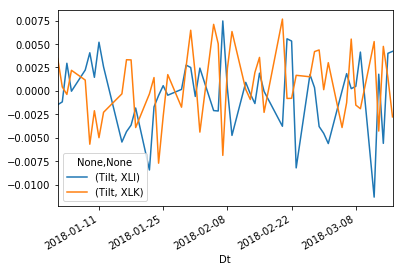

In [33]:
sector_residuals.loc["2018-01-02":"2018-03-16", idx["Tilt", [ "XLI", "XLK"]]].plot()

## Verify one regression

In [34]:
from sklearn import linear_model
lm = linear_model.LinearRegression()

reg_dfs.shape
ind_df = reg_dfs.loc[:, [ ("Pct", "SPY"), ("Tilt", "XLK")]]
dep_df = reg_dfs.loc[:, [ ("Pct", "AKAM")]]
model = lm.fit(ind_df, dep_df)
model.intercept_
model.coef_

(125, 11)

array([ 0.00287118])

array([[ 1.0368274 , -0.08962175]])